In [2]:
import pandas as pd
import numpy as np
import statsmodels as sm
import sklearn as skl
import sklearn.preprocessing as preprocessing
import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
import sklearn.tree as tree
import sklearn.model_selection as model_selection
import seaborn as sns
import math
from sklearn.model_selection import GridSearchCV

# Descripción

In [4]:
census_data_income = pd.read_csv('adult.csv')

In [5]:
census_data_income.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education.num     32561 non-null int64
marital.status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital.gain      32561 non-null int64
capital.loss      32561 non-null int64
hours.per.week    32561 non-null int64
native.country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


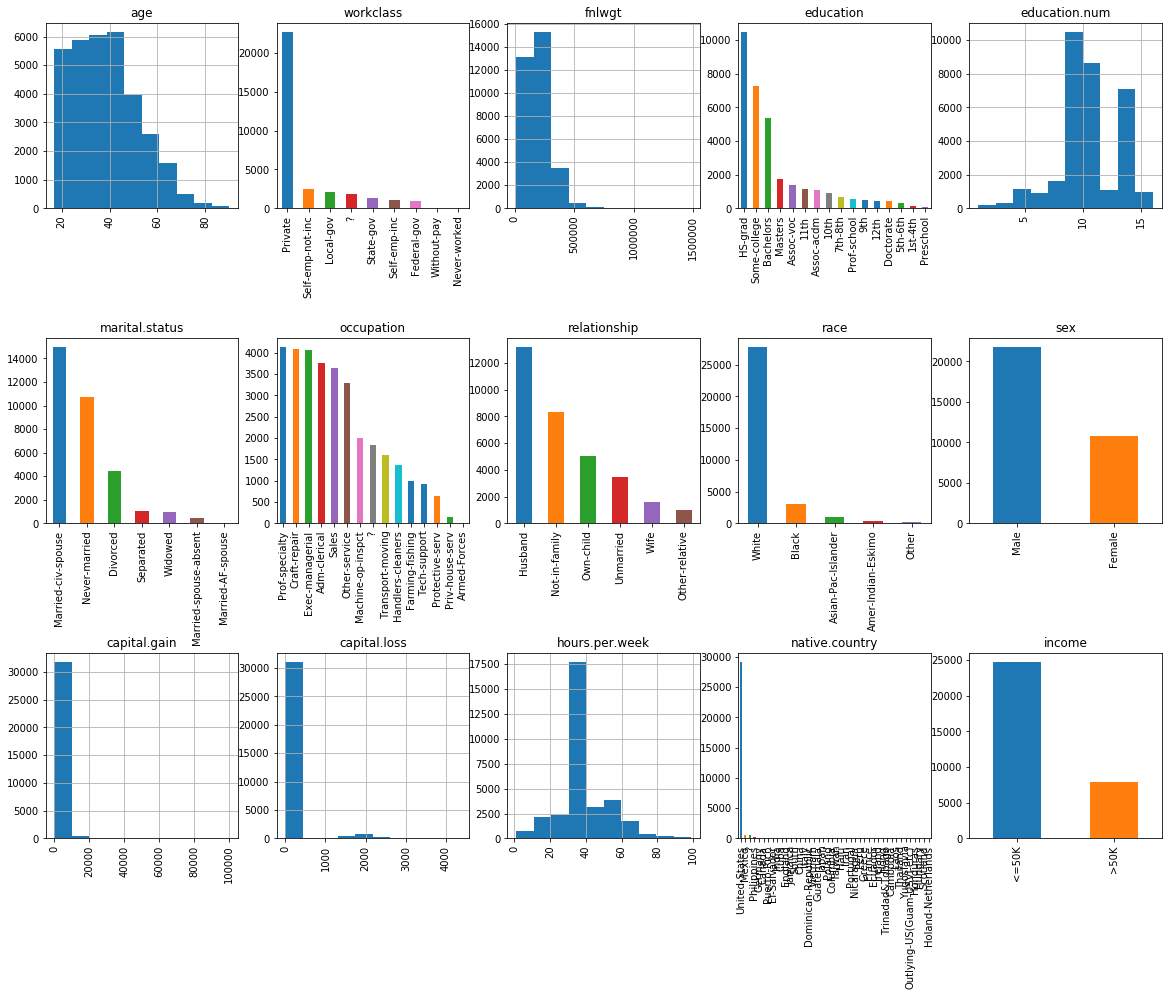

In [6]:
import matplotlib.pyplot as plt

# fuente: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/

fig = plt.figure(figsize=(20,15))
cols = 5
rows = math.ceil(float(census_data_income.shape[1]) / cols)
for i, column in enumerate(census_data_income.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if census_data_income.dtypes[column] == np.object:
        census_data_income[column].value_counts().plot(kind="bar", axes=ax)
    else:
        census_data_income[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [7]:
# Confirmar el sesgo en la data (según las distribuciones generadas
# 'fnlwgt', 'capital.gain' y 'capital.loss' están altamente sesgadas.)

census_data_income.skew()

# Confirma lo observado en las distribuciones; la variable target 'income'
# también está sesgada.

age                0.558743
fnlwgt             1.446980
education.num     -0.311676
capital.gain      11.953848
capital.loss       4.594629
hours.per.week     0.227643
dtype: float64

# Pre-procesamiento de la data

In [8]:
# Convertir '<=50K' a 0 y '>50K' a 1.

data = census_data_income
data['income'] = data['income'].map({'<=50K': 0, '>50K': 1}).astype(int)

In [9]:
# Reemplazar los valores que no se conocen, ?, por la moda.

data = data.replace({'workclass':{'?' : 'Private'}})
data = data.replace({'occupation':{'?' : 'Prof-specialty'}})

In [10]:
# Descatar 'education' porque contiene la misma información que 'education.num'

data = data.drop('education',1)
data.head()

,age,workclass,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Private,77053,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,Private,132870,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,Private,186061,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,0
3,54,Private,140359,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0


In [11]:
# Convertir todos los valores de variables categóricas a dummies
data_d = pd.get_dummies(data)
data_d.head()

,age,fnlwgt,education.num,capital.gain,capital.loss,hours.per.week,income,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native.country_Portugal,native.country_Puerto-Rico,native.country_Scotland,native.country_South,native.country_Taiwan,native.country_Thailand,native.country_Trinadad&Tobago,native.country_United-States,native.country_Vietnam,native.country_Yugoslavia
0,90,77053,9,0,4356,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,82,132870,9,0,4356,18,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,66,186061,10,0,4356,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,54,140359,4,0,3900,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,41,264663,10,0,3900,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


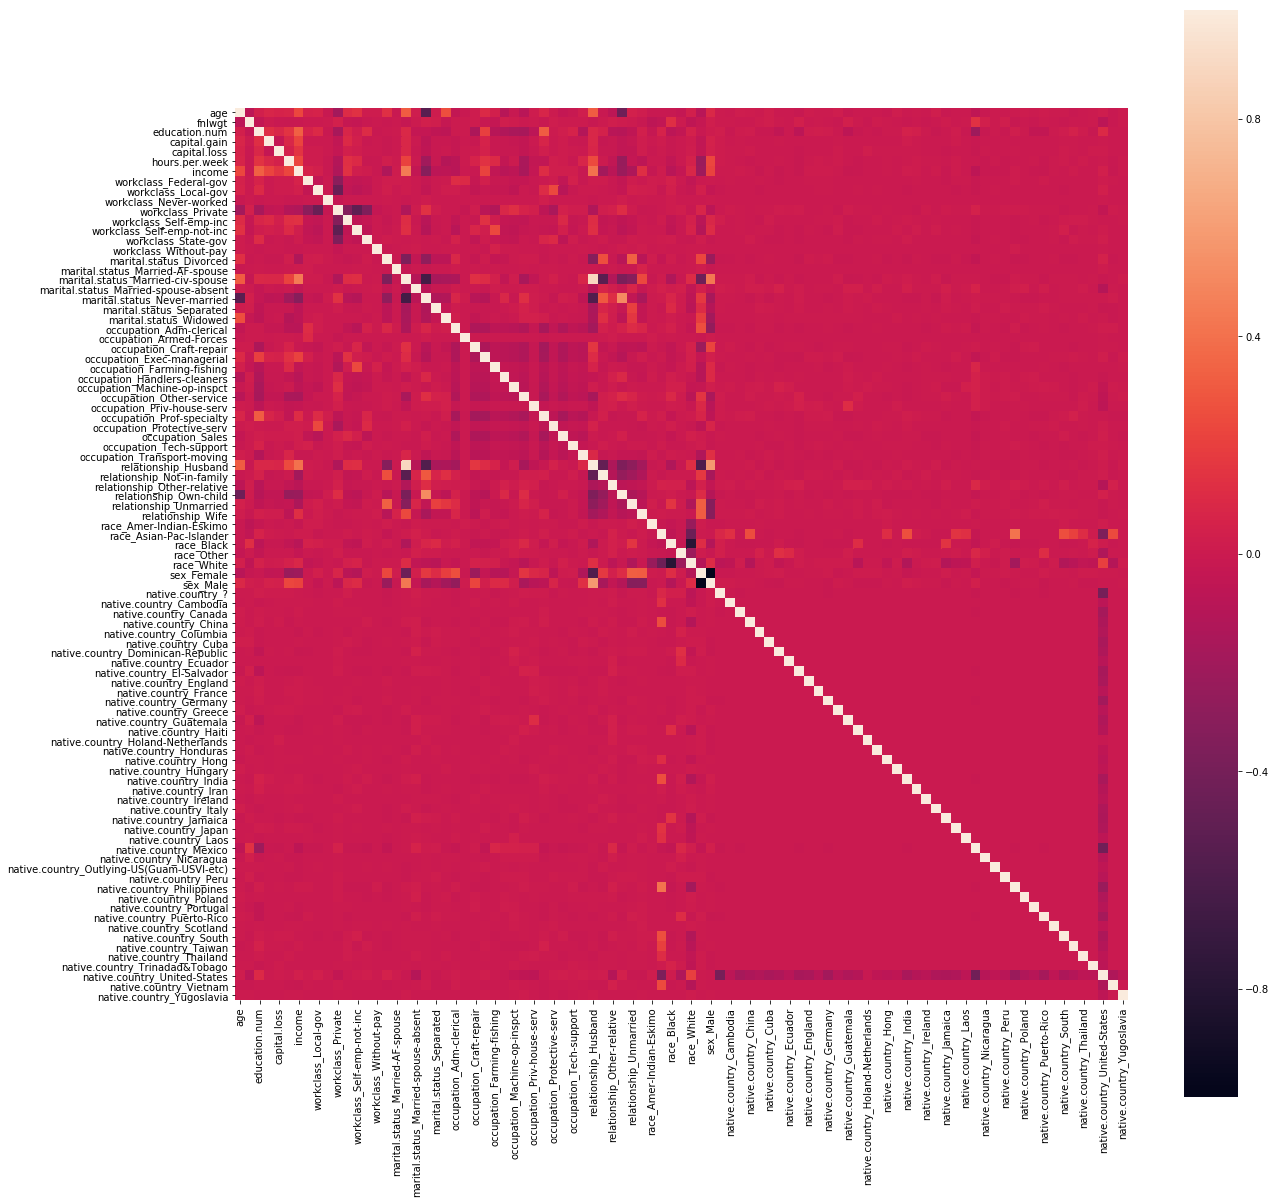

In [12]:
# Verificar correlación

data_corr = data_d.corr()


# fuente: https://www.valentinmihov.com/2015/04/17/adult-income-data-set/
plt.subplots(figsize=(20,20))
sns.heatmap(data_corr, square=True)
plt.show()

# Conjuntos de entrenamiento y prueba

In [13]:
from sklearn.model_selection import train_test_split

X = data_d.drop('income',1)
y = data_d['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [14]:
print ('Entrenamiento: ', len(y_train))
print ('Prueba: ', len(y_test))

Entrenamiento:  26048
Prueba:  6513


# Definición de matriz de confusión

In [15]:
# Del cuadernillo "Evaluación de Aprendizaje"

def matrizC(y_test, predicciones_test):
    matriz_confusion = metrics.confusion_matrix(y_test, predicciones_test)

    # Mapeo según http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    TN = matriz_confusion[0,0]
    FN = matriz_confusion[1,0]
    FP = matriz_confusion[0,1]
    TP = matriz_confusion[1,1]

    print ('              +-----------------+')
    print ('              |   Predicción    |')
    print ('              +-----------------+')
    print ('              |    +   |    -   |')
    print ('+-------+-----+--------+--------+')
    print ('| Valor |  +  |   %d |   %d   |'   % (TP, FN) )
    print ('| real  +-----+--------+--------+')
    print ('|       |  -  |   %d  |   %d  |'    % (FP, TN) )
    print ('+-------+-----+--------+--------+')
    print ()
    print ( 'Exactitud    : ', (TP+TN)/(TP+FN+FP+TN) )

# RandomForestClassifier

In [19]:
from sklearn.ensemble import RandomForestClassifier


param_grid = {'max_depth':np.linspace(1,20,20).astype(int), 'n_estimators':np.linspace(10,100,10).astype(int)}

modelo_rfc = GridSearchCV(RandomForestClassifier(),param_grid)
modelo_rfc.fit(X_train, y_train)

mejor_modelo_rfc = modelo_rfc.best_estimator_

print ("Mejores valores:", modelo_rfc.best_estimator_)
print ("Exactitud en conjunto de entrenamiento :", mejor_modelo_rfc.score(X_train, y_train))
print ("Exactitud en conjunto de prueba    :", mejor_modelo_rfc.score(X_test, y_test))

Mejor valor de n_estimators : RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=17, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=80, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Exactitud en conjunto de entrenamiento : 0.9019886363636364
Exactitud en conjunto de prueba    : 0.862582527253186


In [20]:
# Obtener predicciones

predicciones_test = mejor_modelo_rfc.predict(X_test)

In [21]:
# Obtener matriz de confusión

matrizC(y_test, predicciones_test)

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   888 |   659   |
| real  +-----+--------+--------+
|       |  -  |   236  |   4730  |
+-------+-----+--------+--------+

Exactitud    :  0.862582527253186


In [22]:
# Calcular área bajo la curva ROC

from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicciones_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7632455318011215

# LogisticRegression

In [31]:
from sklearn.linear_model import LogisticRegression


param_grid = {'penalty': ['l1','l2'], 'C': np.linspace(0.001,100,100)}

modelo_lr = GridSearchCV(LogisticRegression(),param_grid)
modelo_lr.fit(X_train, y_train)

mejor_modelo_lr = modelo_lr.best_estimator_

print ("Mejores valores:", modelo_lr.best_estimator_)
print ("Exactitud en conjunto de entrenamiento :", mejor_modelo_lr.score(X_train, y_train))
print ("Exactitud en conjunto de prueba    :", mejor_modelo_lr.score(X_test, y_test))

Mejores valores: LogisticRegression(C=25.25327272727273, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)
Exactitud en conjunto de entrenamiento : 0.8525798525798526
Exactitud en conjunto de prueba    : 0.846307385229541


In [33]:
# Obtener predicciones

predicciones_test = mejor_modelo_lr.predict(X_test)

In [34]:
# Obtener matriz de confusión

matrizC(y_test, predicciones_test)

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   903 |   644   |
| real  +-----+--------+--------+
|       |  -  |   357  |   4609  |
+-------+-----+--------+--------+

Exactitud    :  0.846307385229541


In [35]:
# Calcular área bajo la curva ROC

from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicciones_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.755910781549833

# Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None)

In [24]:
# Obtener predicciones

predicciones_test = nb.predict(X_test)

In [25]:
# Obtener matriz de confusión

matrizC(y_test, predicciones_test)

              +-----------------+
              |   Predicción    |
              +-----------------+
              |    +   |    -   |
+-------+-----+--------+--------+
| Valor |  +  |   479 |   1068   |
| real  +-----+--------+--------+
|       |  -  |   247  |   4719  |
+-------+-----+--------+--------+

Exactitud    :  0.7980961154613849


In [26]:
# Calcular área bajo la curva ROC

from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicciones_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6299466625151874

In [22]:
# Calcular área bajo la curva ROC

from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, predicciones_test)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7632455318011215